In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

/Users/nhn/.pyenv/versions/3.9.0/envs/py390/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('attribution_data.csv')

In [3]:
df.shape

(586737, 6)

In [4]:
df.head(3)

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display


In [5]:
conversion_rate = round(df.groupby('cookie')['conversion'].sum().sum() / df['cookie'].nunique() * 100, 3)
print(f'Rate of user who is conversioned = {conversion_rate}%')

Rate of user who is conversioned = 7.346%


In [6]:
pivot_df = pd.pivot_table(data=df, index='cookie', columns='channel', values='conversion')

In [7]:
pivot_df.head()

channel,Facebook,Instagram,Online Display,Online Video,Paid Search
cookie,,,,,
00000FkCnDfDDf0iC97iC703B,NaN,0.0,0.0,NaN,NaN
0000nACkD9nFkBBDECD3ki00E,NaN,NaN,NaN,NaN,0.0
0003EfE37E93D0BC03iBhBBhF,NaN,NaN,NaN,NaN,0.0
00073CFE3FoFCn70fBhB3kfon,NaN,0.0,NaN,NaN,NaN
00079hhBkDF3k3kDkiFi9EFAD,NaN,NaN,NaN,NaN,0.0


In [8]:
data = pd.DataFrame(np.where(pivot_df.isnull(), 0, 1), columns=pivot_df.columns.values)

label = df.groupby('cookie')['conversion'].sum()
data['conversion'] = pivot_df.join(label, how='left')['conversion'].values

In [9]:
print(f'{data.shape}')
data.head(3)

(240108, 6)


,Facebook,Instagram,Online Display,Online Video,Paid Search,conversion
0,0,1,1,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0


In [10]:
data['conversion'].value_counts()

0    222469
1     17639
Name: conversion, dtype: int64

## Bagged Logistic Regression

In [34]:
X, y = data.drop('conversion', axis=1), data['conversion']

iteration = 100
coef_size = 4

val_avg_acc = 0.0
avg_coef = np.zeros(X.shape[1])
count_coef = np.zeros(X.shape[1])

for _ in tqdm(range(iteration)):
    # sampling the covariates
    coef_idx = list(np.random.choice(np.arange(X.shape[1]), size=coef_size, replace=False))
    X_fs = X.iloc[:, coef_idx]
    # sampling the data
    X_train, X_val, y_train, y_val = train_test_split(X_fs, y, train_size=0.5, shuffle=True, stratify=y)
    # fit Logit model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    # evaluate
    y_pred = model.predict(X_val)
    val_avg_acc += accuracy_score(y_val, y_pred) / iteration
    avg_coef[coef_idx] += model.coef_.reshape(-1)
    count_coef[coef_idx] += 1
avg_coef /= count_coef

print(f'Avg val accuracy = {val_avg_acc:.3f}')
print(f'Avg coef = {avg_coef}')
    

100%|██████████| 100/100 [00:15<00:00,  6.45it/s]

Avg val accuracy = 0.927
Avg coef = [0.25669123 0.34807325 0.0499442  0.48168732 0.0456815 ]


## coef viz

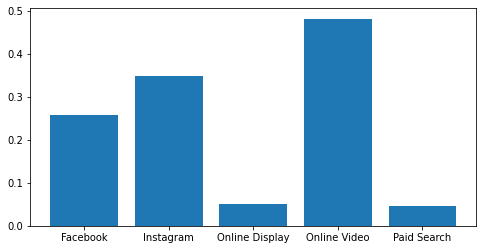

In [35]:
plt.figure(figsize=(8,4))
x = [0,1,2,3,4]
plt.bar(x, avg_coef)
plt.xticks(x, list(X.columns.values))
plt.show()